In [1]:
!pip install torchmetrics
!pip install segmentation-models-pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys
sys.path.append('..')

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader
from pathlib import Path
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = '/content/drive/Othercomputers/내 Mac/Road_Lane_segmentation'
else:
    PROJECT_ROOT = Path.cwd().parents[0]

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용)
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

from src.utils import setup_workspace, load_config, get_device, seed
from src.data import DatasetLoader, get_transforms, split_dataset
from src.models.losses import get_loss
from src.inference import Inferencer, visualize_prediction, visualize_comparison

Environment: Colab
PROJECT_ROOT: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Current working directory: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation


### num_class: 15

In [ ]:


# 62개 클래스 → 15개 그룹 매핑
CLASS_TO_GROUP = {
    # 0: 배경 (무시 영역 및 기타)
    'static': 0, 'dynamic': 0, 'license plate': 0, 'terrain': 0,
    'water': 0, 'ground animal': 0, 'building': 0, 'wall': 0,

    # 1: 주행 가능 도로
    'road': 1, 'bridge': 1, 'tunnel': 1, 'ground': 1, 'rail track': 1,

    # 2: 중앙선 (절대 침범 금지)
    'yesol': 2, 'yedot': 2,

    # 3: 차선 변경 가능 (점선)
    'whdot': 3, 'bldot': 3,

    # 4: 차선 변경 금지 (실선)
    'whsol': 4, 'blsol': 4,

    # 5: 횡단보도
    'crosswalk': 5,

    # 6: 노면 표식
    'stop line': 6, 'general road mark': 6, 'speed bump': 6,
    'protection zone': 6, 'parking': 6, 'prohibition (X mark)': 6,
    'forward': 6, 'left': 6, 'right': 6, 'leftU': 6,
    'leftU-forward': 6, 'right-forward': 6,
    'number 0': 6, 'number 1': 6, 'number 3': 6, 'number 4': 6,
    'number 5': 6, 'number 6': 6, 'number 7': 6,

    # 7: 교통 시설물
    'traffic light': 7, 'traffic sign': 7, 'pole': 7,
    'polegroup': 7, 'rubber cone': 7,

    # 8: 연석 및 경계
    'curb': 8, 'guard rail': 8, 'fence': 8,

    # 9: 보행자 구역
    'sidewalk': 9,

    # 10: 자연/하늘
    'vegetation': 10, 'sky': 10,

    # 11: 차량
    'car': 11, 'truck': 11, 'bus': 11, 'train': 11, 'trailer': 11, 'caravan': 11,

    # 12: 사람/이륜차
    'person': 12, 'bicycle': 12, 'motorcycle': 12, 'rider': 12,

    # 13: 자차
    'ego vehicle': 13,

    # 14: 유도선
    'guidance line': 14,
}

GROUP_NAMES = {
    0: '배경',
    1: '주행 가능 도로',
    2: '중앙선',
    3: '차선 변경 가능',
    4: '차선 변경 금지',
    5: '횡단보도',
    6: '노면 표식',
    7: '교통 시설물',
    8: '연석/경계',
    9: '보행자 구역',
    10: '자연/하늘',
    11: '차량',
    12: '사람/이륜차',
    13: '자차',
    14: '유도선',
}

In [4]:
import torch
from torch.utils.data import Dataset

class GroupedDataset(Dataset):
    """클래스 그룹화 래퍼 - 매핑을 인자로 받음"""
    def __init__(self, base_dataset, class_to_group: dict, num_groups: int):
        self.base_dataset = base_dataset
        self.num_classes = num_groups

        max_id = max(base_dataset.classes.values()) + 1
        self.lut = np.zeros(max_id, dtype=np.uint8)

        for class_name, class_id in base_dataset.classes.items():
            self.lut[class_id] = class_to_group.get(class_name, 0)
        print(f"원본 클래스: {len(base_dataset.classes)} → 그룹: {self.num_classes}")

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, mask = self.base_dataset[idx]
        mask_np = mask.numpy() if isinstance(mask, torch.Tensor) else mask
        return img, torch.from_numpy(self.lut[mask_np]).long()

In [ ]:
from src.training import Trainer

class GroupedTrainer(Trainer):
    def __init__(self, config_path, class_to_group: dict, num_groups: int):
        self.class_to_group = class_to_group
        self.num_groups = num_groups
        super().__init__(config_path)  # 부모 __init__ 호출

    def setup_data(self):
        data_root = self.data_cfg.get("root")
        img_size = tuple(self.data_cfg.get("img_size", [1024, 768]))
        batch_size = self.train_cfg.get("batch_size", 4)
        num_workers = self.train_cfg.get("num_workers", 4)
        transform = get_transforms(img_size)

        train_base = DatasetLoader(data_root, split="train", transform=transform)
        val_base = DatasetLoader(data_root, split="val", transform=transform)

        self.train_dataset = GroupedDataset(train_base, self.class_to_group, self.num_groups)
        self.val_dataset = GroupedDataset(val_base, self.class_to_group, self.num_groups)
        self.num_classes = self.num_groups

        use_pin_memory = self.device.type == "cuda"
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=batch_size,
            shuffle=True, num_workers=num_workers, pin_memory=use_pin_memory
        )
        self.val_loader = DataLoader(
            self.val_dataset, batch_size=batch_size,
            shuffle=False, num_workers=num_workers, pin_memory=use_pin_memory
        )

In [ ]:
SEED = 42
DATA_ROOT = "dataset/Multi_Camera_Semantic_Segmentation"
CONFIG_ROOT = "configs/config.yaml"

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

Env: Colab | Root: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Device: NVIDIA A100-SXM4-40GB


device(type='cuda')

In [ ]:
config = load_config(CONFIG_ROOT)
config

{'data': {'root': 'dataset/Multi_Camera_Semantic_Segmentation',
  'num_classes': 15,
  'img_size': [768, 576]},
 'model': {'name': 'DeepLabV3Plus',
  'encoder': 'resnet101',
  'pretrained': True},
 'training': {'batch_size': 16,
  'accumulation_steps': 3,
  'epochs': 100,
  'lr': 0.0005,
  'weight_decay': 0.0001,
  'dropout': 0.2,
  'early_stop': 15,
  'num_workers': 10,
  'scheduler': {'enabled': True, 'type': 'cosine', 'min_lr': 5e-06}},
 'checkpoint': {'dir': 'checkpoints', 'exp_name': 'class_group_exp1'},
 'loss': {'type': 'ce+dice',
  'weights': {'ce': 0.5, 'dice': 0.5},
  'ignore_index': 255,
  'focal_gamma': 2.0,
  'class_weights': {'enabled': True,
   'method': 'sqrt_inverse',
   'beta': 0.999,
   'normalize': True}},
 'wandb': {'enabled': True,
  'project': 'Road_Lane_Segmentation',
  'run_name': 'class_group_exp1',
  'tags': ['deeplabv3', 'segmentation', 'sqrt_inverse', 'class_group'],
  'num_samples': 2}}

In [ ]:
trainer = GroupedTrainer(CONFIG_ROOT)
trainer.train()

INFO:Trainer:Gradient accumulation enabled with 3 steps.


Device: NVIDIA A100-SXM4-40GB
Train samples: 515
Val samples: 182
원본 클래스: 62 → 그룹: 15
원본 클래스: 62 → 그룹: 15


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

INFO:Trainer:Model: DeepLabV3Plus + resnet101 (CNN, 45.7M params)
INFO:Trainer:Class weights enabled (method: sqrt_inverse)
INFO:Trainer:Loss: ce+dice
INFO:Trainer:Scheduler: CosineAnnealingLR(min_lr=5e-06)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validating: 100%|██████████| 12/12 [01:34<00:00,  7.85s/it]
INFO:Trainer:Epoch 1/100 | Train Loss: 1.2033 | Val Loss: 0.8565 | mIoU: 0.2502 | Accuracy: 0.8694 | Dice: 0.3014 | LR: 0.000500
INFO:Trainer:Logging validation images to W&B for epoch 1...
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_group_exp1/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
INFO:Trainer:Epoch 2/100 | Train Loss: 0.7621 | Val Loss: 0.5544 | mIoU: 0.2982 | Accuracy: 0.9065 | Dice: 0.3591 | LR: 0.000500
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_group_exp1/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]
INFO:Trainer:Epoch 3/100 | Train Loss: 0.6903 | Val Loss: 0.4980 | mIoU: 0.3432 | Accuracy: 0.9249 | Dice: 0.4092 | LR: 0.000500
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_group_exp1/best.pt
INFO:Trainer:

accuracy,▁▄▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
dice,▁▂▃▂▄▅▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
learning_rate,██████████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁
miou,▁▂▂▃▄▅▅▆▆▆▇▇▆▆▇▇▆▇▆▇▇▇▇▇▇███████████████
train_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▂▁▂▁▁▁
val_loss,█▄▅▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.96202
best_miou,0.65414
dice,0.76741
early_stopped,True
learning_rate,0.00011


INFO:Trainer:Training complete. Best mIoU: 0.6541


In [ ]:
import torch
from src.evaluation import Evaluator
from torch.utils.data import DataLoader
from src.models import get_model_from_config

class GroupedEvaluator(Evaluator):
    def __init__(
        self,
        checkpoint_path,
        config_path,
        class_to_group,
        num_groups,
        split="val",
        data_root=None,
        class_info_path=None
    ):
        self.class_to_group = class_to_group
        self.num_groups = num_groups

        # 부모 init 호출 (Evaluator 시그니처에 정확히 맞춤)
        super().__init__(
            checkpoint_path=checkpoint_path,
            config_path=config_path,
            data_root=data_root,
            class_info_path=class_info_path,
            split=split
        )

    def setup_data(self):
        img_size = tuple(self.data_cfg.get("img_size", [1024, 768]))
        transform = get_transforms(img_size=img_size)

        base_dataset = DatasetLoader(
            data_root=self.data_cfg["root"],
            split=self.split,
            transform=transform,
            class_info_path=self.class_info_path
        )

        self.dataset = GroupedDataset(
            base_dataset,
            class_to_group=self.class_to_group,
            num_groups=self.num_groups
        )

        self.num_classes = self.num_groups

        batch_size = self.train_cfg.get("batch_size", 4)
        num_workers = self.train_cfg.get("num_workers", 4)
        use_pin_memory = self.device.type == "cuda"

        self.dataloader = DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=use_pin_memory
        )

    def setup_model(self):
        checkpoint = self.checkpoint

        self.config["data"]["num_classes"] = self.num_groups
        self.config["model"]["pretrained"] = False

        self.model = get_model_from_config(self.config).to(self.device)
        self.model.load_state_dict(checkpoint["model"], strict=True)

        self.model.eval()
        self.logger.info("Loaded grouped model weights from checkpoint")

In [ ]:
checkpoint_path = "checkpoints/DeepLabV3Plus_resnet101_class_group_exp1/best.pt"
evaluator = GroupedEvaluator(config_path=CONFIG_ROOT, checkpoint_path=checkpoint_path)
metrics = evaluator.evaluate()
metrics

In [7]:
import numpy as np

def create_colormap(num_classes):
    colormap = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]  # background는 검정
    return colormap

def mask_to_color(mask, colormap):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in enumerate(colormap):
        color_mask[mask == class_id] = color
    return color_mask

In [8]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

def visualize_segmentation(
    model,
    dataloader,
    device,
    num_classes,
    num_samples=3,
    alpha=0.5
):
    """모델 추론 결과를 시각화"""
    model.eval()
    colormap = create_colormap(num_classes)

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            preds = outputs.argmax(dim=1)

            images = images.cpu()
            masks = masks.cpu()
            preds = preds.cpu()

            for i in range(min(num_samples, images.size(0))):
                img_tensor = images[i].clone()

                # 역정규화 (De-normalization)
                for c in range(3):
                    img_tensor[c] = img_tensor[c] * STD[c] + MEAN[c]

                # Tensor → Numpy Image
                img_np = img_tensor.permute(1, 2, 0).numpy()
                img_np = np.clip(img_np, 0, 1)

                gt_mask = masks[i].numpy()
                pred_mask = preds[i].numpy()

                gt_color = mask_to_color(gt_mask, colormap)
                pred_color = mask_to_color(pred_mask, colormap)

                overlay = img_np * (1 - alpha) + (pred_color / 255.0) * alpha

                fig, axes = plt.subplots(1, 4, figsize=(24, 6))

                axes[0].imshow(img_np)
                axes[0].set_title("Image")

                axes[1].imshow(gt_color)
                axes[1].set_title("GT Mask")

                axes[2].imshow(pred_color)
                axes[2].set_title("Pred Mask")

                axes[3].imshow(overlay)
                axes[3].set_title("Overlay (Prediction)")

                for ax in axes:
                    ax.axis("off")

                plt.tight_layout()
                plt.show()

            break  # 첫 batch만 시각화

In [ ]:
visualize_segmentation(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    num_samples=3
)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(
    model,
    dataloader,
    device,
    num_classes,
    ignore_index=255
):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            preds = outputs.argmax(dim=1)

            preds = preds.view(-1).cpu().numpy()
            targets = masks.view(-1).cpu().numpy()

            valid_mask = targets != ignore_index
            preds = preds[valid_mask]
            targets = targets[valid_mask]

            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(
        all_targets,
        all_preds,
        labels=list(range(num_classes))
    )

    return cm

def plot_confusion_matrix(
    cm,
    class_names=None,
    normalize=True,
    figsize=(8, 6)
):
    if normalize:
        cm = cm.astype(np.float32)
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-6)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.colorbar()

    if class_names is not None:
        plt.xticks(range(len(class_names)), class_names, rotation=90)
        plt.yticks(range(len(class_names)), class_names)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_grouped_confusion_matrix(cm, selected_ids=None, selected_names=None, normalize=True):
    """그룹화된 confusion matrix 시각화"""

    if selected_ids is None:
        # 전체 15개 그룹
        selected_ids = list(range(15))
        selected_names = [GROUP_NAMES[i] for i in selected_ids]

    specific_cm = cm[np.ix_(selected_ids, selected_ids)]

    if normalize:
        specific_cm = specific_cm.astype('float') / (specific_cm.sum(axis=1, keepdims=True) + 1e-7)
        title = "Normalized Grouped Confusion Matrix"
        fmt = '.2f'
    else:
        title = "Grouped Confusion Matrix (Pixel Counts)"
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    plt.imshow(specific_cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.colorbar()

    tick_marks = np.arange(len(selected_names))
    plt.xticks(tick_marks, selected_names, rotation=45, ha='right')
    plt.yticks(tick_marks, selected_names)

    thresh = specific_cm.max() / 2.
    for i, j in np.ndindex(specific_cm.shape):
        plt.text(j, i, format(specific_cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if specific_cm[i, j] > thresh else "black",
                  fontsize=9)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os

def setup_korean_font():
    """Colab/Mac/Windows 한글 폰트 설정"""
    system = platform.system()

    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        # Colab: 나눔고딕 설치
        os.system('apt-get -qq install fonts-nanum > /dev/null 2>&1')
        font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
        rc('font', family='NanumGothic')
        print('Hangul OK in Colab!')

    elif system == 'Darwin':  # Mac
        rc('font', family='Arial Unicode MS')
        print('Hangul OK in Mac!')

    elif system == 'Windows':
        rc('font', family='Malgun Gothic')
        print('Hangul OK in Windows!')

    else:
        print('Unknown system.. sorry')

    plt.rcParams['axes.unicode_minus'] = False

# 실행
setup_korean_font()

Hangul OK in Colab!


In [ ]:
# 차선 관련 그룹 ID
lane_group_ids = [2, 3, 4, 5, 6, 14]  # 중앙선, 차선변경가능, 차선변경금지, 횡단보도, 노면표식,
lane_group_names = [GROUP_NAMES[i] for i in lane_group_ids] # 유도선

cm = compute_confusion_matrix(
      model=evaluator.model,
      dataloader=evaluator.dataloader,
      device=evaluator.device,
      num_classes=15,
      ignore_index=255
  )

plot_grouped_confusion_matrix(cm)

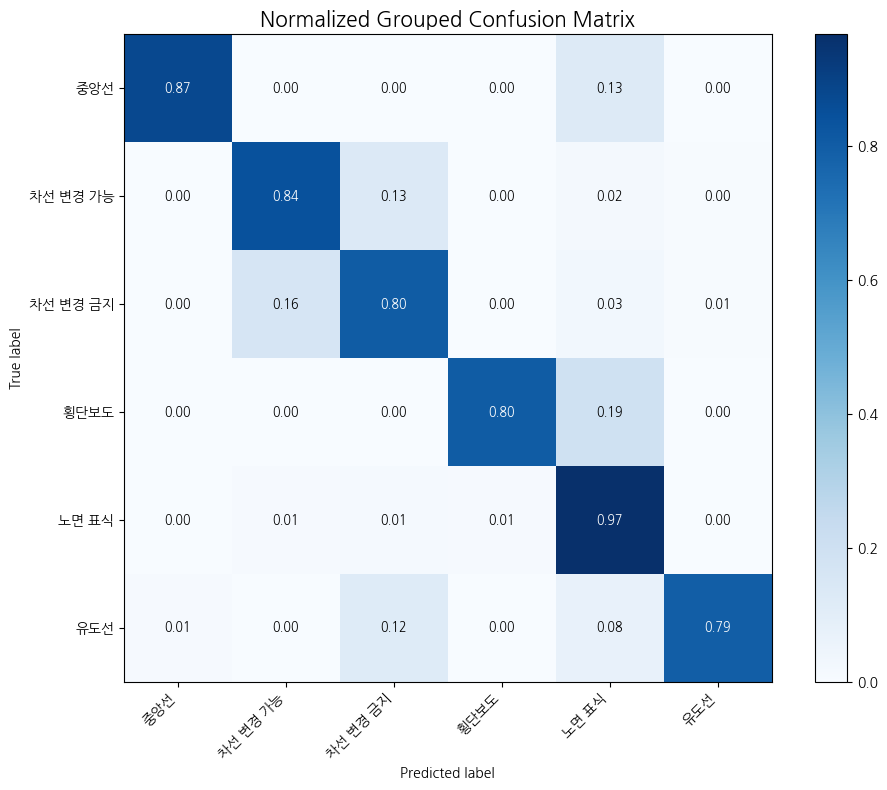

In [ ]:
# 차선 관련 그룹만 시각화
plot_grouped_confusion_matrix(cm, selected_ids=lane_group_ids, selected_names=lane_group_names)

---

### num_class: 20

In [11]:
# [희소 데이터] 샘플 수가 극소량(1~11개)인 노이즈 클래스 통합
LOW_COUNT_CLASSES = [
    'motorcycle', 'terrain', 'number 4', 'ground animal', 'water',
    'number 3', 'train', 'leftU-forward', 'rider', 'fence',
    'number 7', 'right-forward', 'trailer', 'number 1', 'polegroup', 'rail track'
]

CLASS_GROUP_v2 = {
    # 0: 무시 및 자차 영역
    **{cls: 0 for cls in LOW_COUNT_CLASSES},
    'static': 0, 'dynamic': 0, 'ego vehicle': 0,

    'road': 1, 'bridge': 1, 'ground': 1,                       # 1: 일반 주행 도로
    'tunnel': 2,                                               # 2: 터널 영역
    'yesol': 3, 'yedot': 3,                                     # 3: 중앙선 (황색)
    'whdot': 4, 'bldot': 4,                                     # 4: 흰색 점선 (변경 가능)
    'whsol': 5, 'blsol': 5,                                     # 5: 흰색 실선 (변경 금지)
    'stop line': 6, 'crosswalk': 6,                             # 6: 정지선/횡단보도
    'general road mark': 7, 'speed bump': 7, 'protection zone': 7, 'parking': 7,
    'prohibition (X mark)': 7, 'forward': 7, 'left': 7, 'right': 7, 'leftU': 7, # 7: 노면 기호
    'guidance line': 8,                                         # 8: 유도선
    'traffic light': 9, 'traffic sign': 9,                      # 9: 신호등 및 표지판
    'pole': 10,                                                 # 10: 전봇대 (독립 분리)
    'guard rail': 11,                                           # 11: 가드레일 (방호벽)
    'curb': 12,                                                 # 12: 보도 경계 (턱)
    'sidewalk': 13,                                             # 13: 보도 (Sidewalk)
    'car': 14, 'truck': 14, 'bus': 14,                          # 14: 차량 그룹
    'person': 15,                                               # 15: 보행자
    'sky': 16,                                                  # 16: 하늘
    'vegetation': 17,                                           # 17: 나무/수풀
    'building': 18,                                             # 18: 건물
    'wall': 19                                                  # 19: 벽면
}

GROUP_NAMES = {
    0: '무시', 1: '일반도로', 2: '터널', 3: '중앙선', 4: '점선',
    5: '실선', 6: '정지/횡단보도', 7: '노면기호', 8: '유도선', 9: '신호/표지판',
    10: '전봇대', 11: '가드레일', 12: '보도경계', 13: '보도', 14: '차량',
    15: '보행자', 16: '하늘', 17: '나무/숲', 18: '건물', 19: '벽'
}

In [12]:
SEED = 42
DATA_ROOT = "dataset/Multi_Camera_Semantic_Segmentation"
CONFIG_ROOT = "configs/config.yaml"

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

Env: Colab | Root: /content/drive/Othercomputers/내 Mac/Road_Lane_segmentation
Device: NVIDIA A100-SXM4-40GB


device(type='cuda')

In [13]:
config = load_config(CONFIG_ROOT)
config

{'data': {'root': 'dataset/Multi_Camera_Semantic_Segmentation',
  'num_classes': 20,
  'img_size': [768, 576]},
 'model': {'name': 'DeepLabV3Plus',
  'encoder': 'resnet101',
  'pretrained': True},
 'training': {'batch_size': 16,
  'accumulation_steps': 3,
  'epochs': 100,
  'lr': 0.0005,
  'weight_decay': 0.0001,
  'dropout': 0.2,
  'early_stop': 15,
  'num_workers': 10,
  'scheduler': {'enabled': True, 'type': 'cosine', 'min_lr': 5e-06}},
 'checkpoint': {'dir': 'checkpoints', 'exp_name': 'class_group_exp2'},
 'loss': {'type': 'ce+dice',
  'weights': {'ce': 0.5, 'dice': 0.5},
  'ignore_index': 255,
  'focal_gamma': 2.0,
  'class_weights': {'enabled': True,
   'method': 'sqrt_inverse',
   'beta': 0.999,
   'normalize': True}},
 'wandb': {'enabled': True,
  'project': 'Road_Lane_Segmentation',
  'run_name': 'class_group_exp2',
  'tags': ['deeplabv3', 'segmentation', 'sqrt_inverse', 'class_group'],
  'num_samples': 2}}

In [ ]:
trainer = GroupedTrainer(
    CONFIG_ROOT, class_to_group=CLASS_GROUP_v2,
    num_groups=config['data']['num_classes'])

trainer.train()

INFO:Trainer:Gradient accumulation enabled with 3 steps.


Device: NVIDIA A100-SXM4-40GB
Train samples: 515
Val samples: 182
원본 클래스: 62 → 그룹: 20
원본 클래스: 62 → 그룹: 20


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

INFO:Trainer:Model: DeepLabV3Plus + resnet101 (CNN, 45.7M params)
INFO:Trainer:Class weights enabled (method: sqrt_inverse)
INFO:Trainer:Loss: ce+dice
INFO:Trainer:Scheduler: CosineAnnealingLR(min_lr=5e-06)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validating: 100%|██████████| 12/12 [01:34<00:00,  7.87s/it]
INFO:Trainer:Epoch 1/100 | Train Loss: 1.2555 | Val Loss: 1.0250 | mIoU: 0.2020 | Accuracy: 0.8443 | Dice: 0.2400 | LR: 0.000500
INFO:Trainer:Logging validation images to W&B for epoch 1...
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_group_exp2/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]
INFO:Trainer:Epoch 2/100 | Train Loss: 0.8517 | Val Loss: 0.6631 | mIoU: 0.2599 | Accuracy: 0.8766 | Dice: 0.3155 | LR: 0.000500
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_group_exp2/best.pt
INFO:Trainer:mIoU improved. Early stopping counter reset.
Validating: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
INFO:Trainer:Epoch 3/100 | Train Loss: 0.7875 | Val Loss: 0.6032 | mIoU: 0.3089 | Accuracy: 0.8935 | Dice: 0.3762 | LR: 0.000500
INFO:Trainer:Saved: checkpoints/DeepLabV3Plus_resnet101_class_group_exp2/best.pt
INFO:Trainer:

accuracy,▁▃▄▅▆▆▆▇▇▇▇▅▇▇▇▇█▇█▇███▇████████████████
dice,▁▂▃▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██▇████████████████
learning_rate,██████████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁
miou,▁▂▃▄▄▆▆▆▆▇▇▇▇▇▇▇█▇█▇█▇▇█▇███████████████
train_loss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁
val_loss,█▄▄▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94505
best_miou,0.6277
dice,0.74534
early_stopped,True
learning_rate,9e-05


INFO:Trainer:Training complete. Best mIoU: 0.6277


In [20]:
import pandas as pd

checkpoint_path = "checkpoints/DeepLabV3Plus_resnet101_class_group_exp2/best.pt"
evaluator = GroupedEvaluator(
    config_path=CONFIG_ROOT,
    checkpoint_path=checkpoint_path,
    class_to_group=CLASS_GROUP_v2,
    num_groups=20
)

metrics = evaluator.evaluate()
eval_result = pd.DataFrame([metrics])
eval_result

Device: NVIDIA A100-SXM4-40GB
Val samples: 182
원본 클래스: 62 → 그룹: 20


INFO:Evaluator:Loaded grouped model weights from checkpoint
Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]
INFO:Evaluator:Evaluation Results | mIoU: 0.6277 | Accuracy: 0.9468 | Dice: 0.7523


,miou,accuracy,dice
0,0.627699,0.946806,0.752278


In [21]:
visualize_segmentation(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    num_samples=3
)

Output hidden; open in https://colab.research.google.com to view.

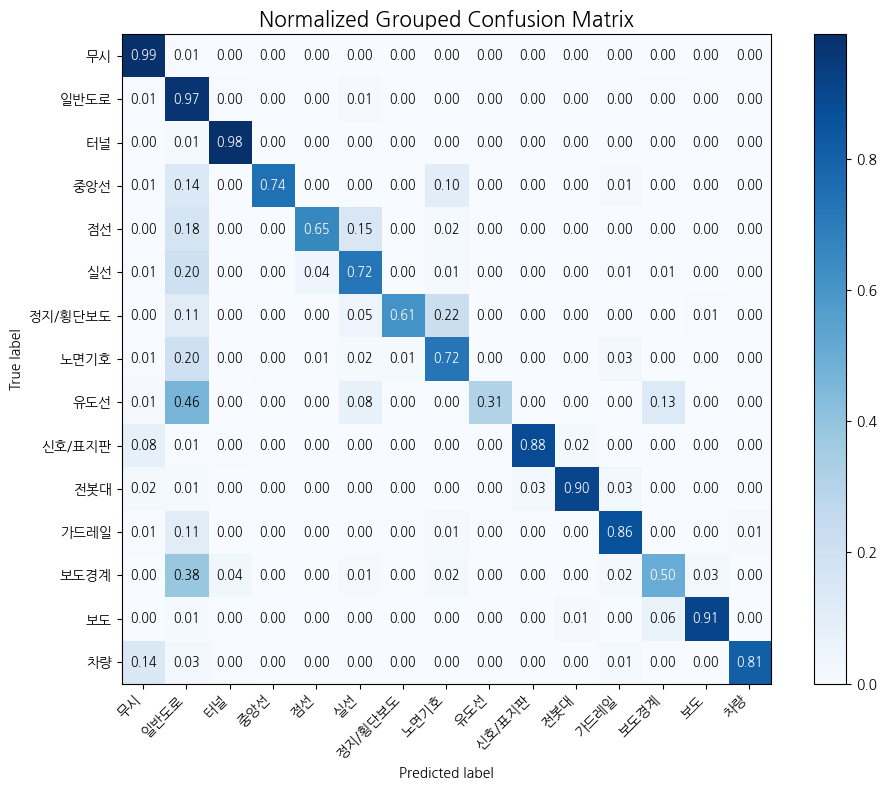

In [23]:
# 차선 관련 그룹 ID
lane_group_ids = [2, 3, 4, 5, 6, 14]  # 중앙선, 차선변경가능, 차선변경금지, 횡단보도, 노면표식,
lane_group_names = [GROUP_NAMES[i] for i in lane_group_ids] # 유도선

cm = compute_confusion_matrix(
      model=evaluator.model,
      dataloader=evaluator.dataloader,
      device=evaluator.device,
      num_classes=20,
      ignore_index=255
  )

plot_grouped_confusion_matrix(cm)